# Telco Churn Classification Project
------------

In [50]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.feature_selection as feat_select
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder

# import models
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# set seaborn defaults

# import custom modules
import acquire
import prepare

#ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [2]:
# https://seaborn.pydata.org/tutorial/color_palettes.html
# https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html

# set seaborn color palette
sns.set_palette('plasma')

# IDEAS: winter (winter_r), magma (magma_r), plasma, Dark2, PuRd, RdPu 
# _r means reversed

In [86]:
# to view current color palette
sns.color_palette()

[(0.32515, 0.006915, 0.639512),
 (0.546157, 0.038954, 0.64701),
 (0.723444, 0.196158, 0.538981),
 (0.85975, 0.360588, 0.406917),
 (0.95547, 0.533093, 0.28549),
 (0.994495, 0.74088, 0.166335)]

<hr style="border-top: 10px groove violet; margin-top: 1px; margin-bottom: 1px"></hr>

## Questions
- From the tableau telco churn project, I found that 50% of month to month customers who churn, do so in the first 7 months
- What makes customers churn in less than 7 months (median tenure)?
    - get all customers from first 7 months, predict who will stay and who will go
    - may need to re calculate because only looking at month to month customers
    - possible difficulty, not enough data for train test split
    - possible drivers, monthly cost, senior citizen, payment method
- What makes Month to Month customers leave within first year? <--
    - filter out contract type (so that's not a driver, because it will most certainly mess with the model)
    - possible drivers, monthly cost (bin this), payment method, senior citizen, EXPLORE SOME MORE
    - monthly cost (maybe change to higher than average and lower than average)


In [3]:
# use acquire function to obtain dataframe
df = acquire.get_telco_data()

In [4]:
df.head()

,customer_id,churn,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,...,streaming_movies,paperless_billing,monthly_charges,total_charges,internet_service_type_id,internet_service_type,contract_type_id,contract_type,payment_type_id,payment_type
0,0030-FNXPP,No,Female,0,No,No,3,Yes,No,No internet service,...,No internet service,No,19.85,57.2,3,None,1,Month-to-month,2,Mailed check
1,0031-PVLZI,Yes,Female,0,Yes,Yes,4,Yes,No,No internet service,...,No internet service,No,20.35,76.35,3,None,1,Month-to-month,2,Mailed check
2,0098-BOWSO,No,Male,0,No,No,27,Yes,No,No internet service,...,No internet service,Yes,19.40,529.8,3,None,1,Month-to-month,1,Electronic check
3,0107-WESLM,Yes,Male,0,No,No,1,Yes,No,No internet service,...,No internet service,Yes,19.85,19.85,3,None,1,Month-to-month,1,Electronic check
4,0114-RSRRW,No,Female,0,Yes,No,10,Yes,No,No internet service,...,No internet service,Yes,19.95,187.75,3,None,1,Month-to-month,3,Bank transfer (automatic)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               7043 non-null   object 
 1   churn                     7043 non-null   object 
 2   gender                    7043 non-null   object 
 3   senior_citizen            7043 non-null   int64  
 4   partner                   7043 non-null   object 
 5   dependents                7043 non-null   object 
 6   tenure                    7043 non-null   int64  
 7   phone_service             7043 non-null   object 
 8   multiple_lines            7043 non-null   object 
 9   online_security           7043 non-null   object 
 10  online_backup             7043 non-null   object 
 11  device_protection         7043 non-null   object 
 12  tech_support              7043 non-null   object 
 13  streaming_tv              7043 non-null   object 
 14  streamin

In [76]:
def counting_values(df):
    for col in df.columns:
        # skip over customer ID column
        if col == 'customer_id':
            continue
        if df[col].dtype == 'object':
            print(df[col].value_counts(dropna=False))

In [43]:
counting_values(df)

No     5174
Yes    1869
Name: churn, dtype: int64
Male      3555
Female    3488
Name: gender, dtype: int64
No     3641
Yes    3402
Name: partner, dtype: int64
No     4933
Yes    2110
Name: dependents, dtype: int64
Yes    6361
No      682
Name: phone_service, dtype: int64
No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64
No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64
No                     3088
Yes                    2429
No internet service    1526
Name: online_backup, dtype: int64
No                     3095
Yes                    2422
No internet service    1526
Name: device_protection, dtype: int64
No                     3473
Yes                    2044
No internet service    1526
Name: tech_support, dtype: int64
No                     2810
Yes                    2707
No internet service    1526
Name: streaming_tv, dtype: int64
No                     2

## Cleaning checklist 
(26 columns to start)
- [x] drop duplicate columns (done in SQL) (23 columns now)
- [x] find and deal with empty values (11 empty ones in total_charges)
- [x] change money columns to floats
- [ ] split train test

- create two seperate prepares **prepare_explore** and **prepare_model**

**prepare_explore**
- [ ] get rid of `_id` columns (except customer, maybe)
- [ ] pick final columns to use in prepare_model

**prepare_model**
- [ ] change all yes's and no's to 0s and 1s
- [ ] change all obejcts to numbers (except where nessicary)
- [ ] create dummy coulmns (gender, 




In [20]:
df.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'internet_service_type_id',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract_type_id',
       'paperless_billing', 'payment_type_id', 'monthly_charges',
       'total_charges', 'churn', 'internet_service_type_id',
       'internet_service_type', 'contract_type_id', 'contract_type',
       'payment_type_id', 'payment_type'],
      dtype='object')

In [93]:
# there are 11 columns that don't have a value for total_charges
# they appear to be spaces (since total_charges is stored as a string and no NaN or Null values appear on my df.info()
df.total_charges.value_counts()

           11
20.2       11
19.75       9
19.9        8
19.65       8
           ..
1301.9      1
4014.6      1
1436.95     1
7251.7      1
1147.45     1
Name: total_charges, Length: 6531, dtype: int64

In [94]:
# convert Total charges to float and deal with emptys 
# use str replace to replace spaces with string 0 then turn entire column to float (may come back and change this to == monthly_charges)
# converting string to 0 becuase after research in SQL, all the values that were empty (aka with the ' ') had a tenure of 0 months
# these people have not paid their first bill yet

df.total_charges = df.total_charges.str.replace(' ', '0').astype(float)

df.total_charges.head()


0     57.20
1     76.35
2    529.80
3     19.85
4    187.75
Name: total_charges, dtype: float64

<AxesSubplot:xlabel='senior_citizen', ylabel='count'>

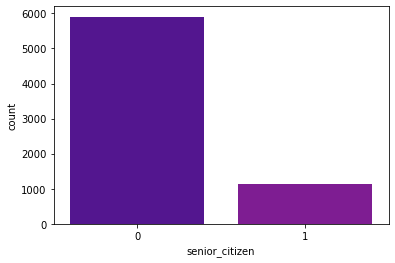

In [95]:
# practice graphing one of the variables
# discovered countplot! exactly what I needed 
# there is a depreciation warning that was silenced but it totally works like this so I'm using it.
sns.countplot(df.senior_citizen)

In [96]:
# function to plot counts all the object columns 
def plot_counts(df):
    for col in df.columns:
        # skip over customer ID
        if col == 'customer_id':
            continue
        if df[col].dtype == 'object':
            sns.countplot(df[col])
            plt.title(f'{col} counts')
            plt.show()

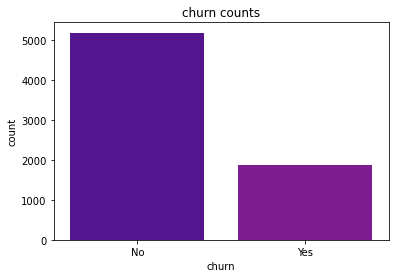

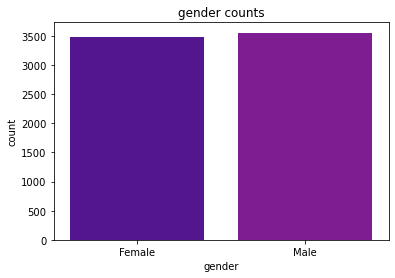

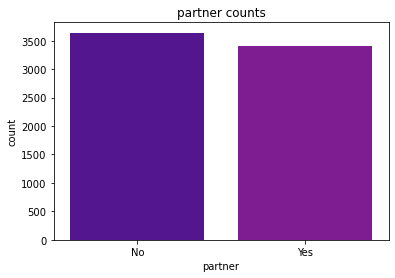

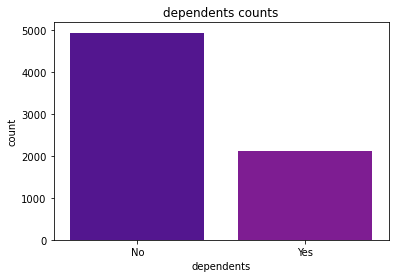

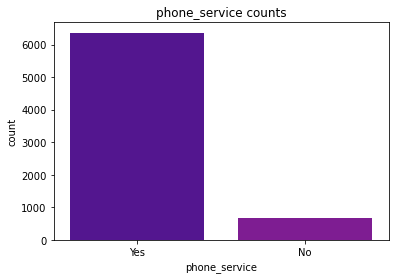

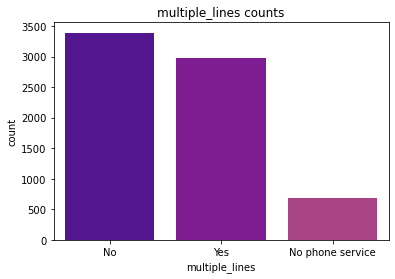

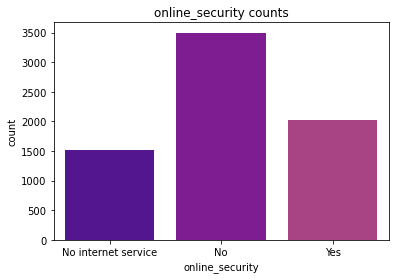

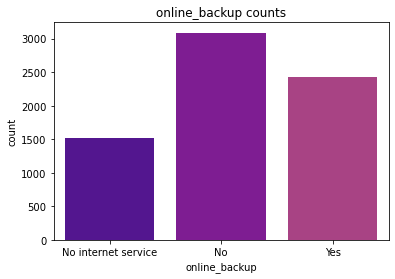

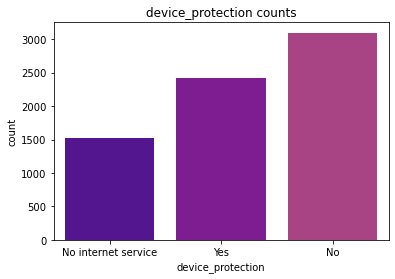

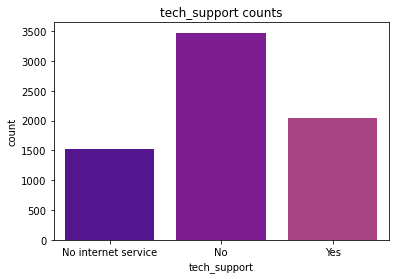

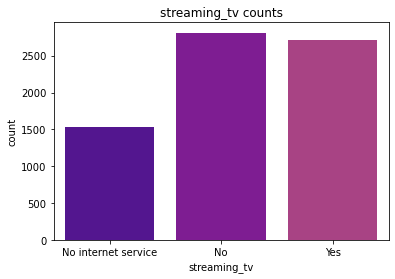

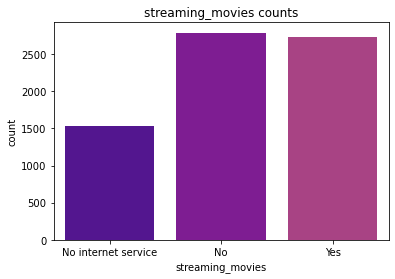

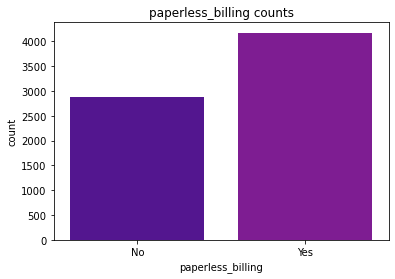

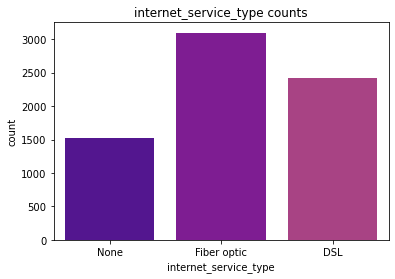

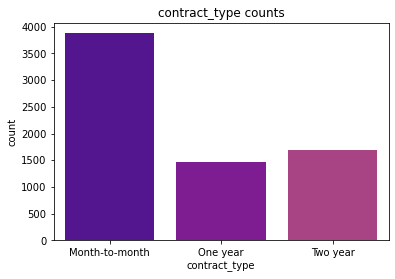

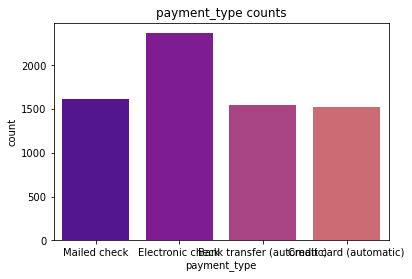

In [97]:
plot_counts(df)

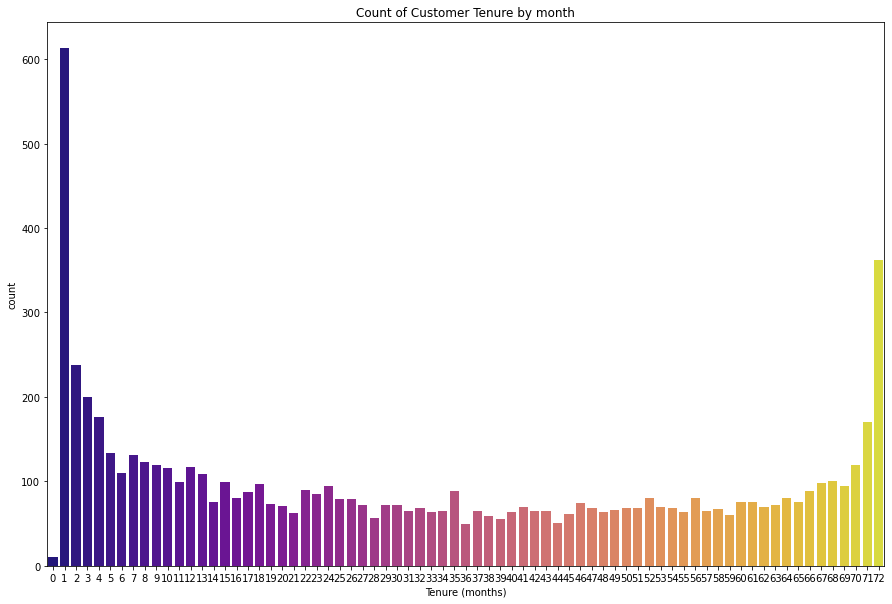

In [107]:
plt.figure(figsize=(15,10))
sns.countplot(df.tenure, palette=('plasma'))
plt.title('Count of Customer Tenure by month')
plt.xlabel('Tenure (months)')
plt.show()

In [142]:
# people who's tenure is less than 12 months. 999 of those people have churned already
df[df.tenure < 12].churn.value_counts()

No     1070
Yes     999
Name: churn, dtype: int64

In [143]:
# median values of people who have been at the company less than a year
df[df.tenure < 12].median().T

senior_citizen                0.00
tenure                        3.00
monthly_charges              56.05
total_charges               157.65
internet_service_type_id      2.00
contract_type_id              1.00
payment_type_id               2.00
dtype: float64

In [144]:
# total churn counts
df.churn.value_counts()

No     5174
Yes    1869
Name: churn, dtype: int64

In [151]:
# median month of tenure for people who churn
# 50% of all people who churn do so before 10 months
# MORE than half of the customers churn before 1 year
df[df.churn == "Yes"].tenure.median()

10.0

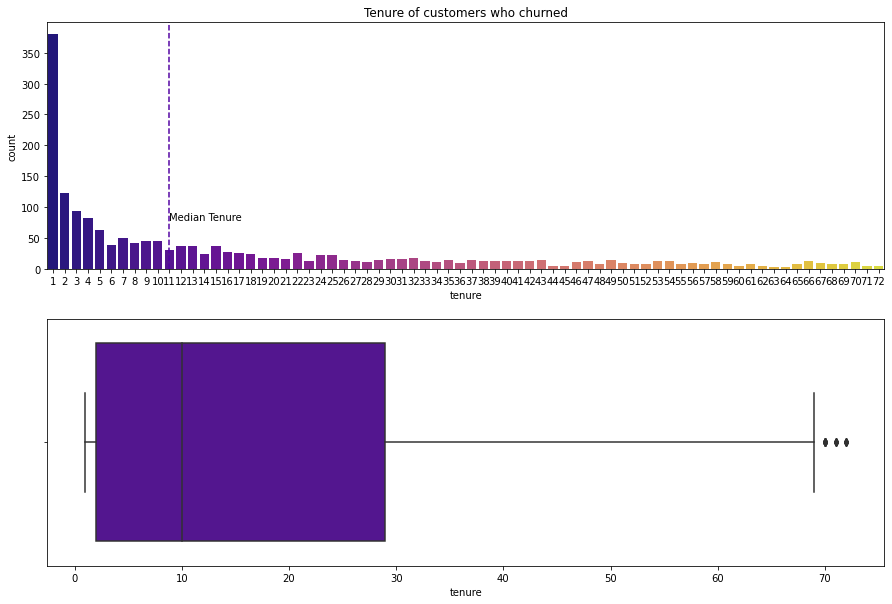

In [214]:
tenure_before_churn = df[df.churn == "Yes"].tenure

plt.figure(figsize=(15, 10))
plt.subplot(211)
sns.countplot(tenure_before_churn, palette=('plasma'))
plt.annotate(text= 'Median Tenure',xy=(10,80))
plt.axvline(x=10, linestyle= '--')
plt.title('Tenure of customers who churned')
plt.subplot(212)
sns.boxplot(tenure_before_churn)
plt.show()

<hr style="border-top: 10px groove violet; margin-top: 1px; margin-bottom: 1px"></hr>

## SPLIT DATA

In [5]:
# use functions to get clean fresh set. called telco_df
train, validate, test = prepare.prep_telco(acquire.get_telco_data())

In [6]:
# Change senior_citizen to astype string for exploration. The 0s and 1s were wreaking havoc with my chart below
train.senior_citizen = train.senior_citizen.astype(str)

In [7]:
train.senior_citizen = train.senior_citizen.str.replace('0', 'no').str.replace('1','yes')

## Explore
- What makes people churn within the first 12 months
    - (these are mostly month to month customers)


In [7]:
cols = list(train.columns)

In [189]:
cols = ['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'internet_service_type',
 'contract_type',
 'payment_type']

cols2 = [ 'monthly_charges',
         'total_charges']

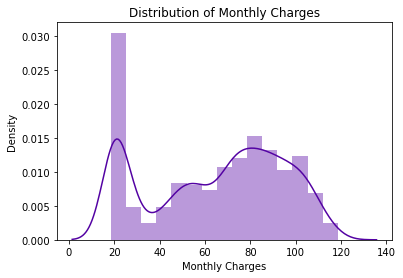

In [328]:
# distribution of Monthly Charges
sns.distplot(x = train.monthly_charges)
plt.title('Distribution of Monthly Charges')
plt.xlabel('Monthly Charges')
plt. show()

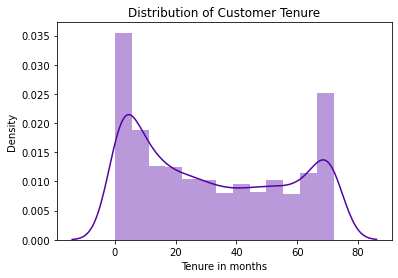

In [8]:
# distribution of tenure
sns.distplot(x = train.tenure)
plt.title('Distribution of Customer Tenure')
plt.xlabel('Tenure in months')
plt. show()

<AxesSubplot:xlabel='tenure', ylabel='churn'>

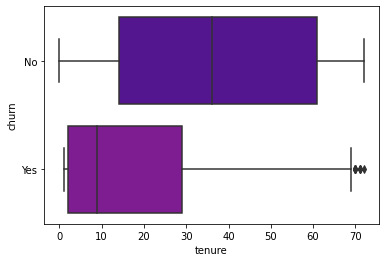

In [9]:
# this is the entire demographic! 
# compare this to all the variables to see a difference
sns.boxplot(x = train.tenure, y = train.churn)

<AxesSubplot:xlabel='tenure', ylabel='gender'>

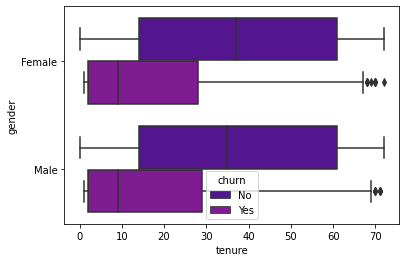

In [27]:
sns.boxplot(x = train.tenure, y = train['gender'], hue = train.churn)

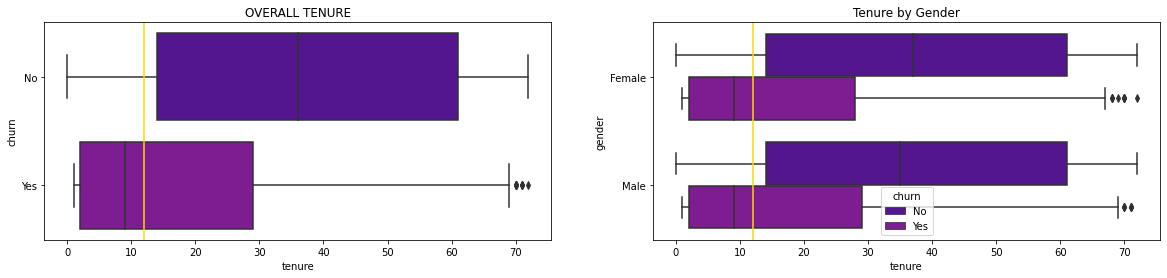

In [88]:
plt.figure(figsize = (20,4))
plt.subplot(121)
sns.boxplot(x = train.tenure, y = train.churn)
plt.title('OVERALL TENURE')
plt.axvline(x = 12, c='gold')

plt.subplot(122)
sns.boxplot(x = train.tenure, y = train['gender'], hue = train.churn)
plt.title('Tenure by Gender')
plt.axvline(x = 12, c='gold')

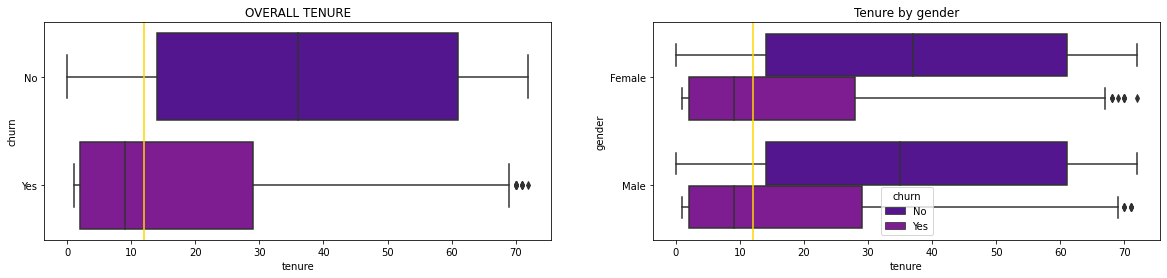

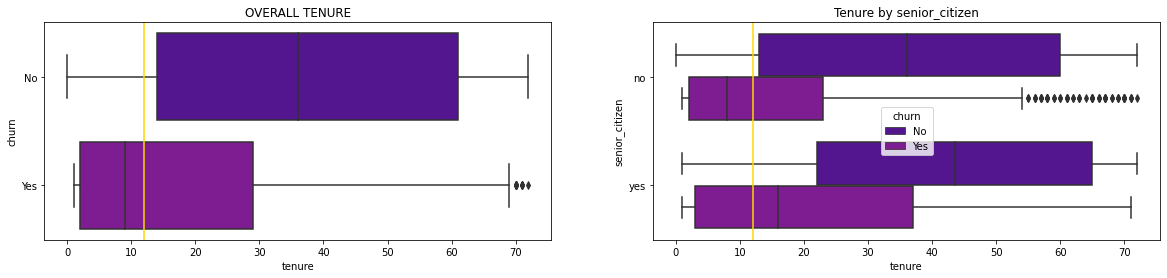

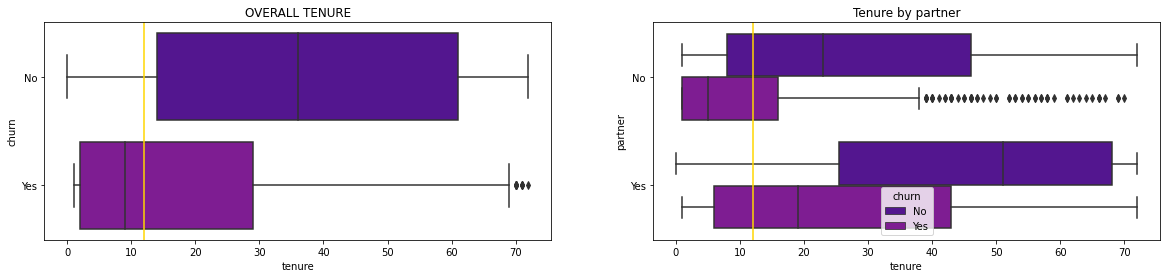

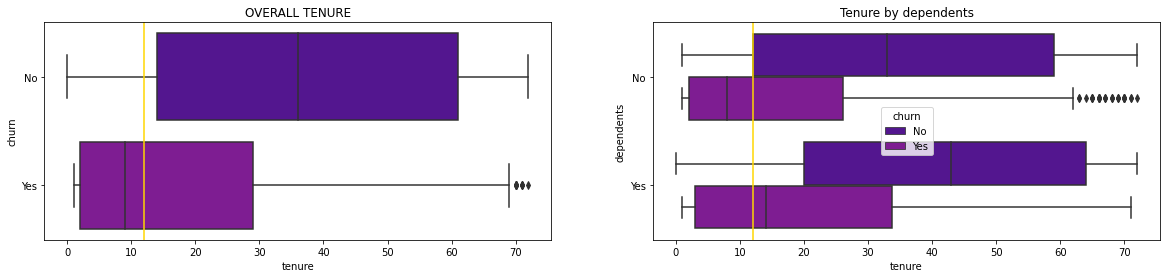

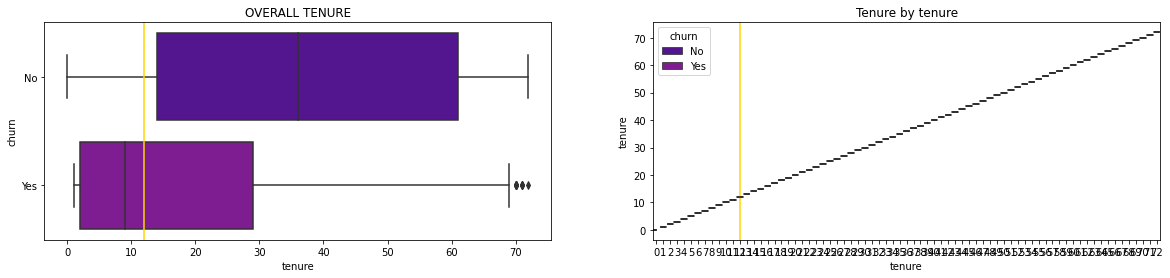

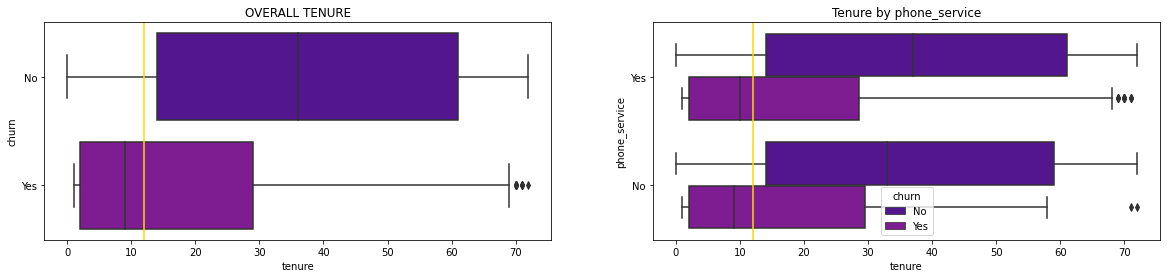

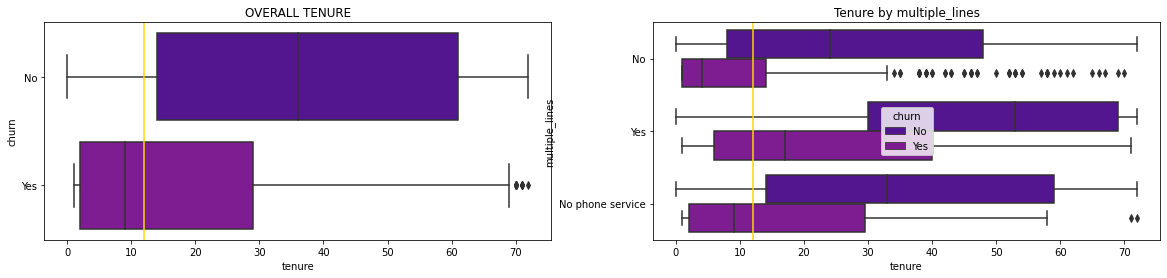

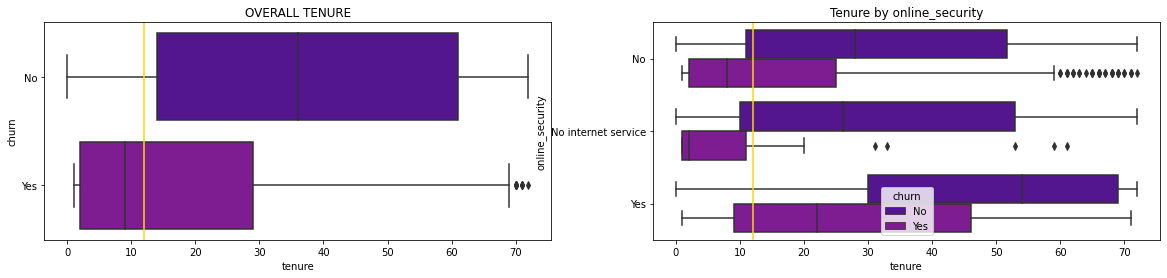

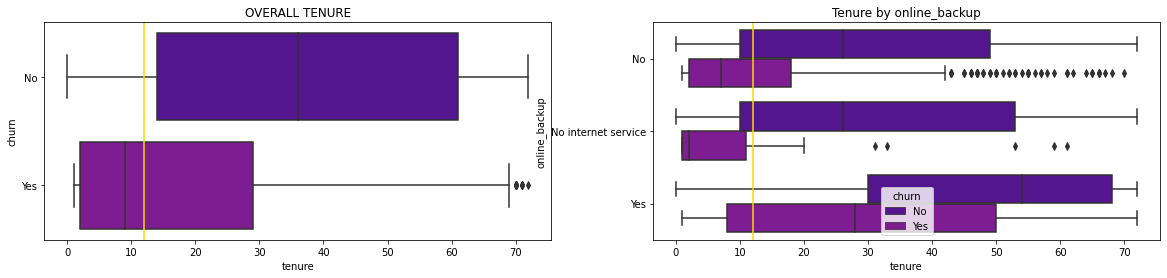

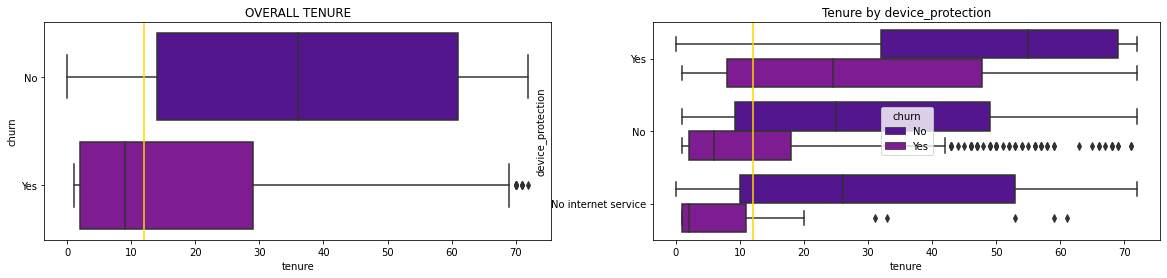

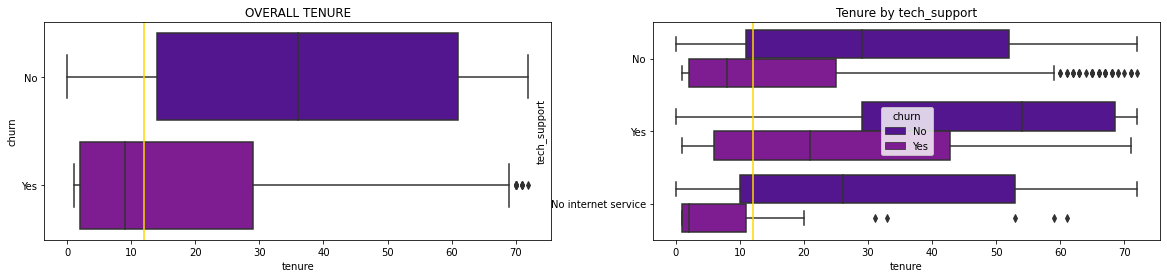

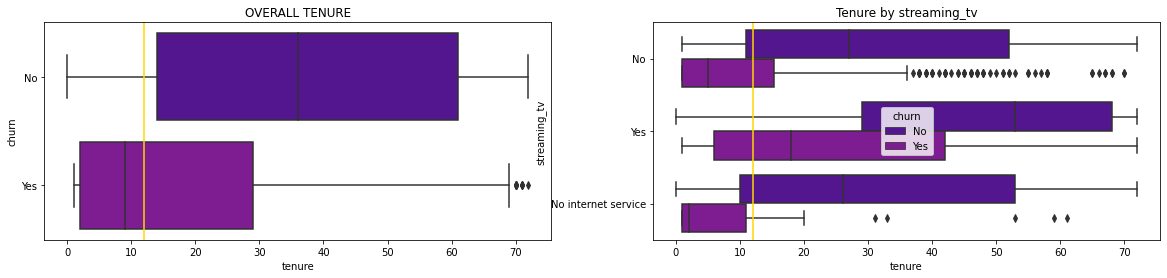

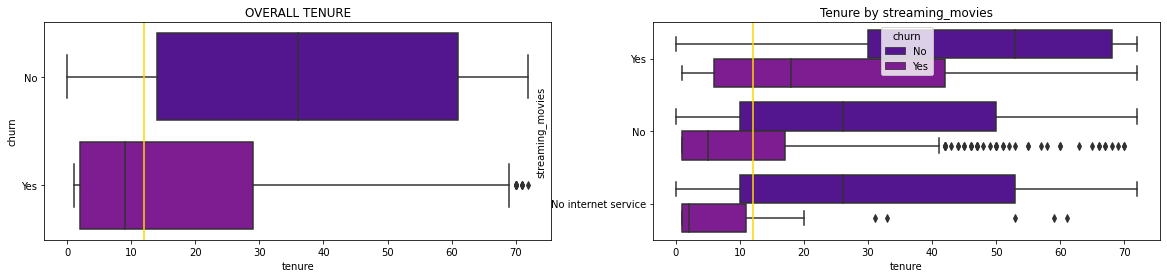

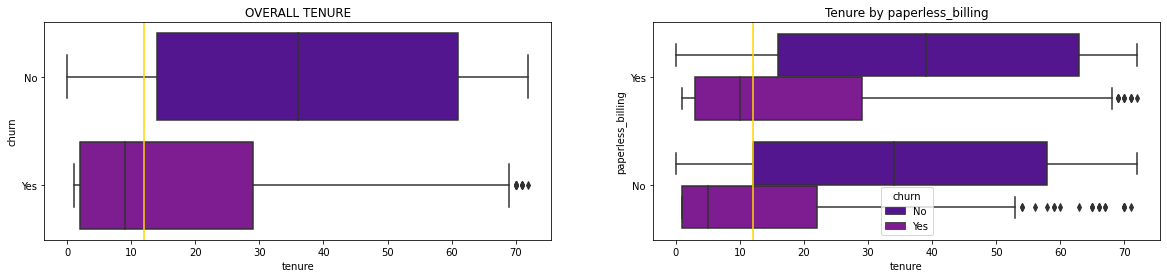

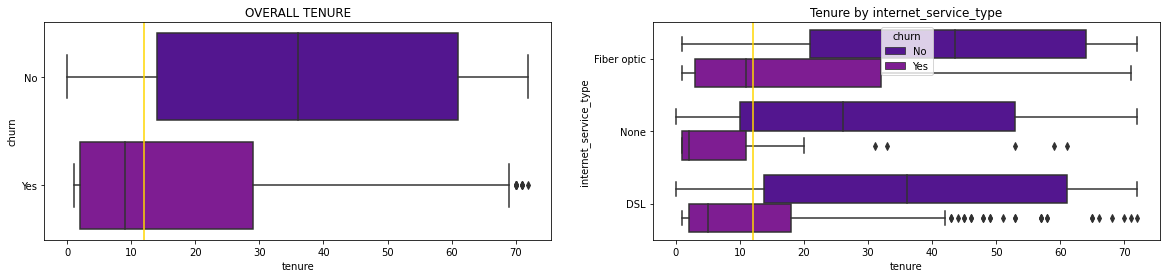

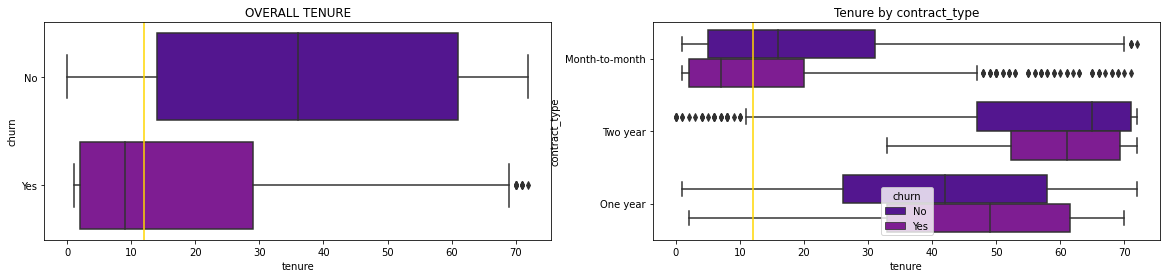

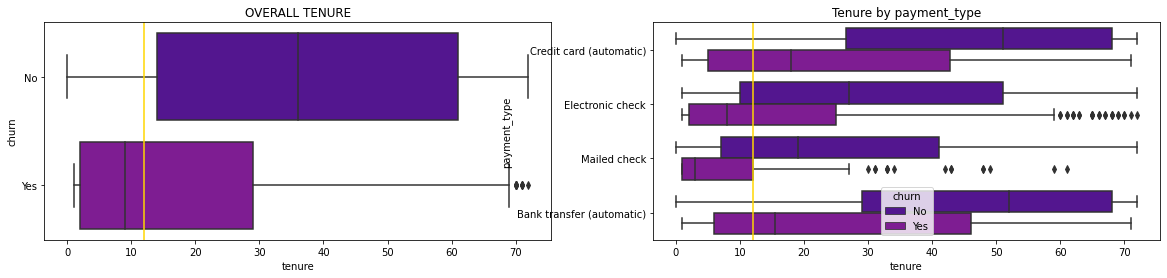

In [89]:
# gold line is for looking at customers with tenure less than a year
for col in cols:
    plt.figure(figsize = (20,4))
    plt.subplot(121)
    sns.boxplot(x = train.tenure, y = train.churn)
    plt.title('OVERALL TENURE')
    plt.axvline(x = 12, c='gold')
    
    plt.subplot(122)
    sns.boxplot(x = train.tenure, y = train[col], hue = train.churn)
    plt.title(f'Tenure by {col}')
    plt.axvline(x = 12, c='gold')

In [65]:
train[train.tenure < 12].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,1187.0,4.389217,3.311814,0.00,1.000,3.00,7.00,11.00
monthly_charges,1187.0,56.865712,26.104317,18.75,29.150,59.65,78.65,107.95
total_charges,1187.0,256.251179,246.433598,0.00,70.625,166.30,379.85,1222.05
internet_service_type_id,1187.0,1.890480,0.739036,1.00,1.000,2.00,2.00,3.00
contract_type_id,1187.0,1.112890,0.399064,1.00,1.000,1.00,1.00,3.00
payment_type_id,1187.0,1.834878,0.982836,1.00,1.000,2.00,2.00,4.00


In [ ]:
sns.histplot(train.)

## Takeaways from box plots
- Not having internet, and paying by a mailed check, big chunk of those customers (lower 3 quartiles) churn before 1 year
- Less significant but still big chunk of people, people who have dsl and aren't in paperless billing
- seems like less services they have, more likely they are to churn

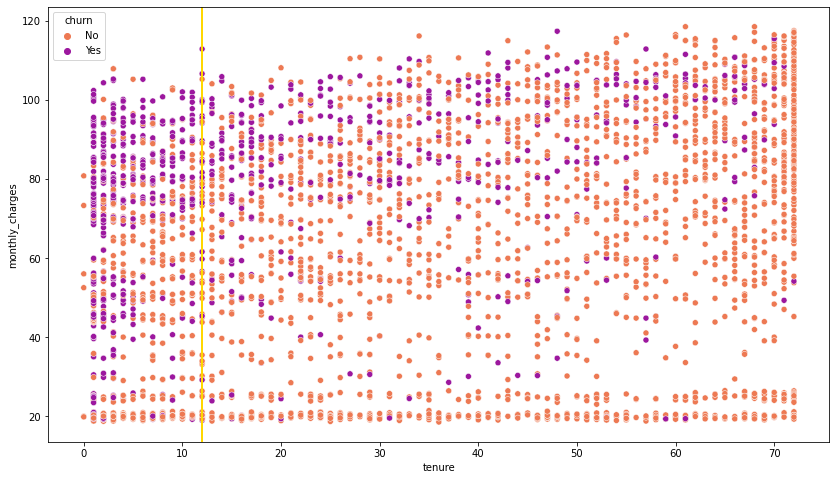

In [106]:
plt.figure(figsize = (14,8))
sns.scatterplot(x = train.tenure, y = train.monthly_charges, hue=train.churn, palette=('plasma_r'))
plt.axvline(x = 12, c = 'gold', linewidth = 2)

## Takeaways from first scatter
- a lot of the purple dots (people who churned) are on the high end
- Take a look to the left of the gold line, Lots of purple dots are high up
- customers pay lots of money and then decide to leave. 
- break this down by contract type

In [ ]:
plt.figure(figsize = (14,8))
sns.scatterplot(x = train.tenure, y = train.monthly_charges, hue=train.churn, palette=('plasma_r'))
plt.axvline(x = 12, c = 'gold', linewidth = 2)

In [100]:
train[train.contract_type_id == 1].tenure

1148     9
1162    32
679     21
209      1
2779     7
        ..
628     43
1820    19
3172    26
1341    56
1238    35
Name: tenure, Length: 2181, dtype: int64

In [115]:
# create list of contract type names for my graph loop below
contract_type_list = list(train.contract_type.value_counts().index)
contract_type_list

['Month-to-month', 'Two year', 'One year']

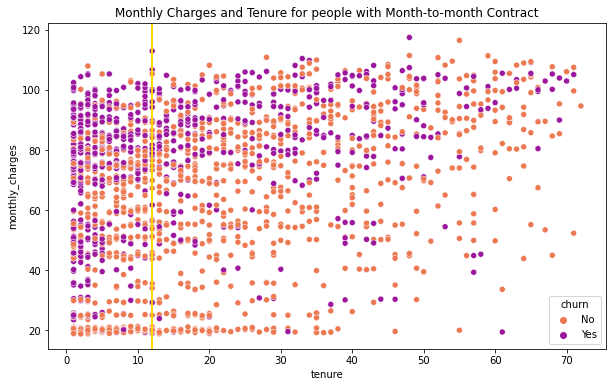

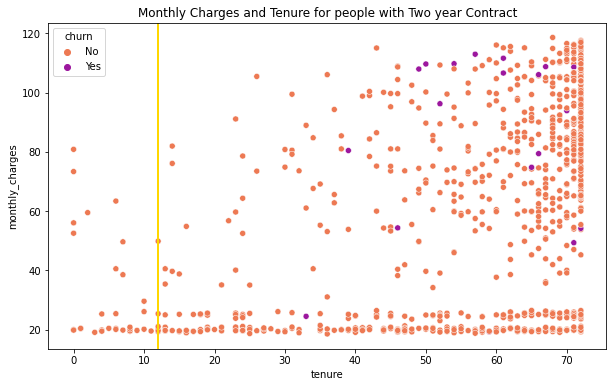

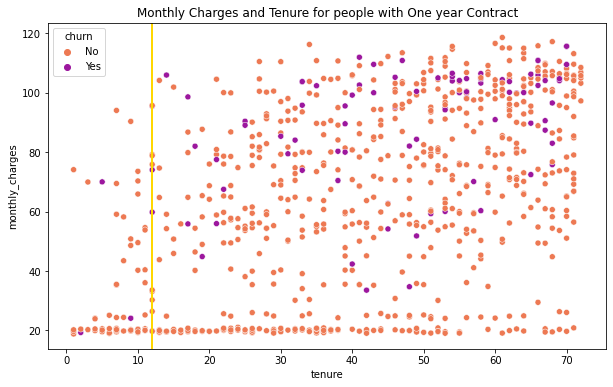

In [124]:
# loop to print tenure vs contract type
for contract_type in contract_type_list:
    plt.figure(figsize = (10,6))
    sns.scatterplot(x = train[train.contract_type == contract_type].tenure, y = train.monthly_charges, hue=train.churn, palette=('plasma_r'))
    plt.axvline(x = 12, c = 'gold', linewidth = 2)
    plt.title(f'Monthly Charges and Tenure for people with {contract_type} Contract')

## Takeaway from Scatters
- Like I learned from my other project, month to month customers churn before 12 months and have high monthly costs

In [150]:
crosstab = pd.crosstab(train.churn, train.senior_citizen)

In [151]:
crosstab


senior_citizen,no,yes
churn,,
No,2533,364
Yes,785,261


In [155]:
# alpha = 0.05
chi2, p, degf, expected = stats.chi2_contingency(crosstab)

In [156]:
chi2, p

(87.48675630901229, 8.484602138169008e-21)

## Selecting features with chi2

In [356]:
# choose my features for the model
# pclass, sex (m or f), sibsp (family members, siblings and spouse)

y_col = 'churn'

# do the capital X lowercase y thing for train test and split
# X is the data frame of the features, y is a series of the target
X_train, y_train = train[cols], train[y_col]
X_validate, y_validate = validate[cols], validate[y_col]
X_test, y_test = test[cols], test[y_col]

In [202]:
feat_select.chi2(X_train, y_train)

(array([3.94696797e-01, 7.43987888e+01, 3.52227174e+01, 6.51918677e+01,
        9.25338570e+03, 2.05363147e-01, 6.69913763e+00, 3.23861199e+02,
        1.45592042e+02, 1.12761623e+02, 3.15185168e+02, 3.85901669e+00,
        6.97166987e+00, 6.26512545e+01, 4.91842644e+00, 6.44801661e+02,
        2.86198232e+01]),
 array([5.29840840e-001, 6.38281535e-018, 2.94073061e-009, 6.79493584e-016,
        0.00000000e+000, 6.50426255e-001, 9.64595543e-003, 2.08864165e-072,
        1.59414459e-033, 2.43340534e-026, 1.62069136e-070, 4.94793187e-002,
        8.28101835e-003, 2.46747738e-015, 2.65717081e-002, 3.01754873e-142,
        8.80759019e-008]))

In [208]:
X_new = feat_select.SelectKBest(feat_select.chi2, k=3).fit_transform(X_train, y_train)

In [212]:
X_new.shape

(3943, 3)

In [218]:
mostSig = pd.DataFrame(X_new)
mostSig.head()

,0,1,2
0,9,0,0
1,32,0,0
2,21,0,0
3,1,1,0
4,62,2,2


In [217]:
X_train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,internet_service_type,contract_type,payment_type
1148,0,0,0,0,9,1,0,0,0,2,0,0,2,1,1,0,1
1162,1,1,1,0,32,1,2,0,0,2,2,2,2,1,1,0,2
679,0,0,1,0,21,1,0,0,0,0,2,2,0,1,1,0,2
209,1,0,0,0,1,1,0,1,1,1,1,1,1,0,2,0,3
6827,0,0,1,0,62,1,2,2,2,0,2,2,2,1,0,2,2


Example code to get the list of new features
``` python

from sklearn.feature_selection import SelectKBest, chi2
X_5_best= SelectKBest(chi2, k=5).fit(x_train, y_train)
mask = X_5_best.get_support() #list of booleans for selected features
new_feat = [] 
for bool, feature in zip(mask, x_train.columns):
     if bool:
     new_feat.append(feature)
print(‘The best features are:{}’.format(new_feat)) # The list of your 5 best features
```

### Info about Encoding [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [185]:
label_encoder = LabelEncoder()
train['streaming_tv'] = label_encoder.fit_transform(train['streaming_tv'])
#train['gender'] = label_encoder.fit_transform(train['gender'])

In [186]:
train.streaming_tv

1148    0
1162    2
679     2
209     1
6827    2
       ..
5793    1
1341    2
1238    2
3972    1
6330    2
Name: streaming_tv, Length: 3943, dtype: int64

In [187]:
label_encoder.inverse_transform(train['streaming_tv'])

array(['No', 'Yes', 'Yes', ..., 'Yes', 'No internet service', 'Yes'],
      dtype=object)

In [339]:
# loop, loops though my cols keep track of 
label_encoder = LabelEncoder()
for col in cols:
    train[col] = label_encoder.fit_transform(train[col])

In [341]:
# change churns to 0s and 1s
train['churn_num'] = label_encoder.fit_transform(train['churn'])

In [342]:
train.head()

,customer_id,churn,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,...,paperless_billing,monthly_charges,total_charges,internet_service_type_id,internet_service_type,contract_type_id,contract_type,payment_type_id,payment_type,churn_num
1148,2959-FENLU,No,0,0,0,0,9,1,0,0,...,1,85.30,781.40,2,1,1,0,4,1,0
1162,3001-CBHLQ,Yes,1,1,1,0,32,1,2,0,...,1,104.90,3351.55,2,1,1,0,1,2,1
679,0682-USIXD,No,0,0,1,0,21,1,0,0,...,1,86.05,1818.90,2,1,1,0,1,2,0
209,3785-NRHYR,No,1,0,0,0,1,1,0,1,...,0,19.65,19.65,3,2,1,0,2,3,0
6827,6691-CCIHA,No,0,0,1,0,62,1,2,2,...,1,84.95,5150.55,1,0,3,2,1,2,0


In [194]:
train['churn'] = label_encoder.fit_transform(train['churn'])

In [195]:
train.head()

,customer_id,churn,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,...,streaming_movies,paperless_billing,monthly_charges,total_charges,internet_service_type_id,internet_service_type,contract_type_id,contract_type,payment_type_id,payment_type
1148,2959-FENLU,0,0,0,0,0,9,1,0,0,...,2,1,85.30,781.40,2,1,1,0,4,1
1162,3001-CBHLQ,1,1,1,1,0,32,1,2,0,...,2,1,104.90,3351.55,2,1,1,0,1,2
679,0682-USIXD,0,0,0,1,0,21,1,0,0,...,0,1,86.05,1818.90,2,1,1,0,1,2
209,3785-NRHYR,0,1,0,0,0,1,1,0,1,...,1,0,19.65,19.65,3,2,1,0,2,3
6827,6691-CCIHA,0,0,0,1,0,62,1,2,2,...,2,1,84.95,5150.55,1,0,3,2,1,2


## Hypothesis
$H_0$ : internet service type independent from churn in first year

$H_a$: internet service type not independent from churn in first year

alpha = 0.05

$H_0$: Paying by a mailed check (payment type) is independent to whether or not a person churns within the first year

$H_a$: Paying by a mailed check (payment type) is not independent from churn in first year

alpha = 0.05


In [345]:
((train['tenure'] < 12) == True) & ((train['churn'] == 'Yes') == True)

1148    False
1162    False
679     False
209     False
6827    False
        ...  
5793    False
1341    False
1238    False
3972    False
6330    False
Length: 3943, dtype: bool

In [346]:
# create new column of churned in a year for crosstab purposes 

train['less_than_a_year'] = (((train['tenure'] < 12) == True) & ((train['churn'] == 'Yes') == True)).astype(int)

train[['churn', 'tenure', 'less_than_a_year']].head(20)

,churn,tenure,less_than_a_year
1148,No,9,0
1162,Yes,32,0
679,No,21,0
209,No,1,0
6827,No,62,0
2779,Yes,7,1
4616,No,66,0
380,No,35,0
2514,Yes,18,0
1173,No,8,0


In [347]:
# create crosstab for hypothesis 1 internet service type independant from churn under a year
crosstab = pd.crosstab(train.less_than_a_year, train.internet_service_type)

In [348]:
crosstab

internet_service_type,0,1,2
less_than_a_year,,,
0,1201,1371,797
1,160,373,41


In [349]:
chi2, p, degf, expected = stats.chi2_contingency(crosstab)

In [350]:
def contingency_metrics(chi2, p, degf, expected, crosstab, alpha = 0.05):
    print('Observed\n')
    print(crosstab.values)
    print('--------\nExpected\n')
    print(expected.astype(int))
    print('--------\n')
    print(f'chi^2 = {chi2:.4f}')
    print(f'p     = {p:.4f}')
    if p < alpha:
        print(f'\nWe can reject the null hypothesis. Yay!')
    else:
        print(f'\nWe cannot reject the null hypothesis')
              

In [351]:
contingency_metrics(chi2, p, degf, expected, crosstab)

Observed

[[1201 1371  797]
 [ 160  373   41]]
--------
Expected

[[1162 1490  716]
 [ 198  253  121]]
--------

chi^2 = 136.9304
p     = 0.0000

We can reject the null hypothesis. Yay!


In [306]:
# create crosstab for hypothesis 2 payment type independent from churn in first year
crosstab2 = pd.crosstab(train.less_than_a_year, train.internet_service_type)

In [314]:
chi2, p, degf, expected = stats.chi2_contingency(crosstab2)
contingency_metrics(chi2, p, degf, expected, crosstab2)

Observed

[[1201 1371  797]
 [ 160  373   41]]
--------
Expected

[[1162 1490  716]
 [ 198  253  121]]
--------

chi^2 = 136.9304
p     = 0.0000

We can reject the null hypothesis. Yay!


### Hypothesis Takeaways
$H_0$ : internet service type independent from churn in first year <font color=blue>CAN REJECT</font>

$H_a$: internet service type not independent from churn in first year <font color=green>Evidence to suggest alternate hypothesis</font> 

alpha = 0.05

$H_0$: Paying by a mailed check (payment type) is independent to whether or not a person churns within the first year <font color=blue>CAN REJECT</font>

$H_a$: Paying by a mailed check (payment type) is not independent from churn in first year <font color=green>Evidence to suggest alternate hypothesis</font>

alpha = 0.05

###  Baseline Accuracy
- Baseline to be created is the most common (which will be no one churns!) 
- should this be the case though? should we try to just predict everyone will leave and then beat that with our models? 


In [10]:
# Import with improved prep function
train, validate, test = prepare.prep_telco_model(df)

In [8]:
# value counts for all people churned 0 and not churned 1 within the first year
# 0 is more so not churned it is! 
train.less_than_a_year.value_counts()

0    3384
1     559
Name: less_than_a_year, dtype: int64

In [11]:
# add column that is the baselone 0 = not churned
train['baseline'] = 0

In [12]:
baseline = train.baseline

In [13]:
# clean this up once you have y_train figured out. 
baseline_class_report = classification_report(train.churn, train.baseline, zero_division=True)
print(baseline_class_report)

              precision    recall  f1-score   support

           0       0.73      1.00      0.85      2897
           1       1.00      0.00      0.00      1046

    accuracy                           0.73      3943
   macro avg       0.87      0.50      0.42      3943
weighted avg       0.81      0.73      0.62      3943



In [40]:
# clean this up once you have y_train figured out. 
baseline_class_report = classification_report(train.less_than_a_year, train.baseline, zero_division=True)
print(baseline_class_report)

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      3369
           1       1.00      0.00      0.00       574

    accuracy                           0.85      3943
   macro avg       0.93      0.50      0.46      3943
weighted avg       0.88      0.85      0.79      3943



### Takeaways baseline - baseline is predicting no one churns
- Baseline accuracy for all churn is 73%
- baseline accuracy for all predicting people leaving in less than a year is 85%

<hr style="border-top: 10px groove violet; margin-top: 1px; margin-bottom: 1px"></hr>

# Modeling
# Model 1

In [14]:
list(train.columns)

['customer_id',
 'churn',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'internet_service_type',
 'contract_type',
 'payment_type',
 'less_than_a_year',
 'baseline']

In [35]:
#decide on features to put into model
X_cols = ['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'internet_service_type',
 'contract_type',
 'payment_type']

#target
y_col = 'less_than_a_year'

In [36]:
# create X/ys
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.all_aboard_the_X_train(X_cols, y_col, train, validate, test)

## Model 1 Decision Tree
- Hyper Parameters: max leaf nodes = 10
- Precision rate of 91.8 percent
- should I optimize for 

In [37]:
# create model 1
model1 = DecisionTreeClassifier(max_leaf_nodes= 10)

# fit to train dataset
model1.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=10)

[Text(472.65882352941173, 448.47, 'X[4] <= 11.5\ngini = 0.249\nsamples = 3943\nvalue = [3369, 574]'),
 Text(420.1411764705882, 366.93, 'X[14] <= 67.3\ngini = 0.499\nsamples = 1187\nvalue = [613, 574]'),
 Text(210.0705882352941, 285.39, 'X[8] <= 0.5\ngini = 0.422\nsamples = 634\nvalue = [442, 192]'),
 Text(105.03529411764706, 203.84999999999997, 'X[15] <= 229.075\ngini = 0.496\nsamples = 287\nvalue = [156, 131]'),
 Text(52.51764705882353, 122.31, 'gini = 0.49\nsamples = 191\nvalue = [82, 109]'),
 Text(157.5529411764706, 122.31, 'gini = 0.353\nsamples = 96\nvalue = [74, 22]'),
 Text(315.1058823529412, 203.84999999999997, 'X[4] <= 3.5\ngini = 0.29\nsamples = 347\nvalue = [286, 61]'),
 Text(262.5882352941176, 122.31, 'gini = 0.396\nsamples = 169\nvalue = [123, 46]'),
 Text(367.6235294117647, 122.31, 'gini = 0.154\nsamples = 178\nvalue = [163, 15]'),
 Text(630.2117647058824, 285.39, 'X[15] <= 120.0\ngini = 0.427\nsamples = 553\nvalue = [171, 382]'),
 Text(525.1764705882352, 203.849999999999

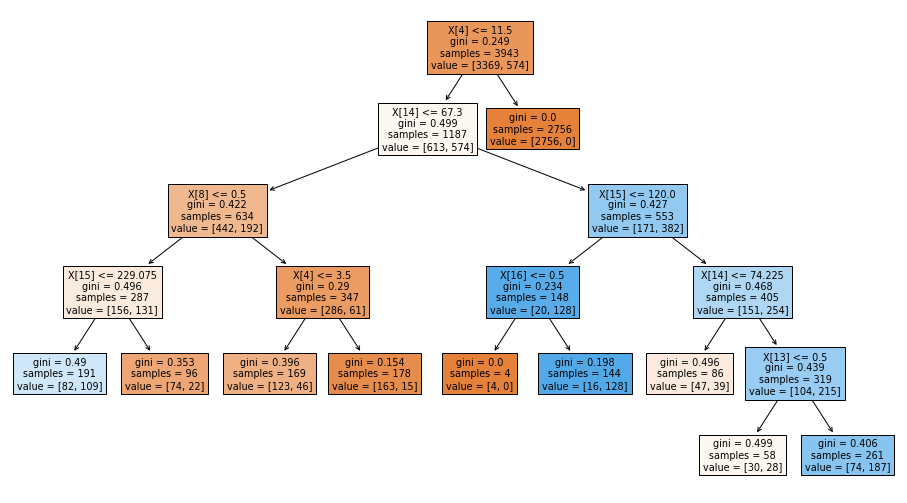

In [38]:
# visualize model1
plt.figure(figsize = (16,9))
plot_tree(model1, filled = True)

In [30]:
# Function for model performs. move to explore.py
def model_performs (X_df, y_df, model):
    '''
    Take in a X_df, y_df and model  and fit the model , make a prediction, calculate score (accuracy), 
    confusion matrix, rates, clasification report.
    X_df: train, validate or  test. Select one
    y_df: it has to be the same as X_df.
    model: name of your model that you prevously created 
    
    Example:
    mmodel_performs (X_train, y_train, model1)
    '''

    #prediction
    pred = model.predict(X_df)

    #score = accuracy
    acc = model.score(X_df, y_df)

    #conf Matrix
    conf = confusion_matrix(y_df, pred)
    mat =  pd.DataFrame ((confusion_matrix(y_df, pred )),index = ['actual_not_churned','actual_churned'], columns =['pred_not_churned','pred_churned' ])
    rubric_df = pd.DataFrame([['True Negative', 'False positive'], ['False Negative', 'True Positive']], columns=mat.columns, index=mat.index)
    cf = rubric_df + ': ' + mat.values.astype(str)

    #assign the values
    tp = conf[1,1]
    fp =conf[0,1] 
    fn= conf[1,0]
    tn =conf[0,0]

    #calculate the rate
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    tnr = tn/(tn+fp)
    fnr = fn/(fn+tp)

    #classification report
    clas_rep =pd.DataFrame(classification_report(y_df, pred, output_dict=True)).T
    clas_rep.rename(index={'0': "not churned", '1': "churned"}, inplace = True)
    print(f'''
    The accuracy for our model is {acc:.4%}

    The True Positive Rate is {tpr:.3%},    The False Positive Rate is {fpr:.3%},
    The True Negative Rate is {tnr:.3%},    The False Negative Rate is {fnr:.3%}

    ________________________________________________________________________________
    ''')
    print('''
    The positive is  'churned'

    Confusion Matrix
    ''')
    display(cf)
    print('''

    ________________________________________________________________________________
    
    Classification Report:
    ''')
    display(clas_rep)
   

In [39]:
model_performs(X_train, y_train, model1)


    The accuracy for our model is 91.8336%

    The True Positive Rate is 73.868%,    The False Positive Rate is 5.105%,
    The True Negative Rate is 94.895%,    The False Negative Rate is 26.132%

    ________________________________________________________________________________
    

    The positive is  'churned'

    Confusion Matrix
    


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 3197,False positive: 172
actual_churned,False Negative: 150,True Positive: 424




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
not churned,0.955184,0.948946,0.952055,3369.000000
churned,0.711409,0.738676,0.724786,574.000000
accuracy,0.918336,0.918336,0.918336,0.918336
macro avg,0.833297,0.843811,0.838421,3943.000000
weighted avg,0.919696,0.918336,0.918970,3943.000000


In [41]:
model_performs(X_validate, y_validate, model1)


    The accuracy for our model is 90.7156%

    The True Positive Rate is 65.000%,    The False Positive Rate is 5.438%,
    The True Negative Rate is 94.562%,    The False Negative Rate is 35.000%

    ________________________________________________________________________________
    

    The positive is  'churned'

    Confusion Matrix
    


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 1391,False positive: 80
actual_churned,False Negative: 77,True Positive: 143




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
not churned,0.947548,0.945615,0.946580,1471.000000
churned,0.641256,0.650000,0.645598,220.000000
accuracy,0.907156,0.907156,0.907156,0.907156
macro avg,0.794402,0.797808,0.796089,1691.000000
weighted avg,0.907699,0.907156,0.907423,1691.000000


In [45]:
y_pred = model1.predict(X_validate)

In [47]:
class_report = classification_report(y_validate, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1471
           1       0.64      0.65      0.65       220

    accuracy                           0.91      1691
   macro avg       0.79      0.80      0.80      1691
weighted avg       0.91      0.91      0.91      1691



## Takeaways Model 1
- Model 1 performed very well with a 90.7% accuracy rate
- Predicting someone will churn is what we're aiming for
- Worst case is missing someone who will churn (False Negative), so optimization for recall would be a bonus
- this model has a fair recal 65% (a little over fit in the recall deparment to the train model)
- very high precision though, 95%, aka good at predicting someone will stay, not hard though since a lot of people do

<hr style="border-top: 10px groove violet; margin-top: 1px; margin-bottom: 1px"></hr>

# Model 2
- Type KNN
- using only categorical variables (i.e. no monthly or total charges, or tenure)

In [48]:
#decide on features to put into model
X_cols = ['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'internet_service_type',
 'contract_type',
 'payment_type']

#target
y_col = 'less_than_a_year'

In [49]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.all_aboard_the_X_train(X_cols, y_col, train, validate, test)

In [52]:
model2 = KNeighborsClassifier(n_neighbors=5)
model2.fit(X_train, y_train)

KNeighborsClassifier()

In [55]:
model_performs(X_train, y_train, model2)


    The accuracy for our model is 88.5113%

    The True Positive Rate is 45.296%,    The False Positive Rate is 4.126%,
    The True Negative Rate is 95.874%,    The False Negative Rate is 54.704%

    ________________________________________________________________________________
    

    The positive is  'churned'

    Confusion Matrix
    


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 3230,False positive: 139
actual_churned,False Negative: 314,True Positive: 260




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
not churned,0.911400,0.958741,0.934471,3369.000000
churned,0.651629,0.452962,0.534430,574.000000
accuracy,0.885113,0.885113,0.885113,0.885113
macro avg,0.781514,0.705852,0.734450,3943.000000
weighted avg,0.873584,0.885113,0.876235,3943.000000


In [57]:
model_performs(X_validate, y_validate, model2)


    The accuracy for our model is 84.7428%

    The True Positive Rate is 28.182%,    The False Positive Rate is 6.798%,
    The True Negative Rate is 93.202%,    The False Negative Rate is 71.818%

    ________________________________________________________________________________
    

    The positive is  'churned'

    Confusion Matrix
    


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 1371,False positive: 100
actual_churned,False Negative: 158,True Positive: 62




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
not churned,0.896664,0.932019,0.914000,1471.000000
churned,0.382716,0.281818,0.324607,220.000000
accuracy,0.847428,0.847428,0.847428,0.847428
macro avg,0.639690,0.606919,0.619304,1691.000000
weighted avg,0.829800,0.847428,0.837320,1691.000000


## Takeaways Model 2
- this model did not perform better than model 2
- it did well at guessing people who stayed but did very bad guessing people who churned
- the True Positive rate was 28%!!! Bad at guessing churn which is what we need
- recall is BAD

<hr style="border-top: 10px groove violet; margin-top: 1px; margin-bottom: 1px"></hr>

# Model 3
- model 3 will be a random forest 
- variables, top ones that I chose with statistical testing 
- Will probably make a model 4 with all the columns

In [58]:
#decide on features to put into model
X_cols = [
 'senior_citizen',
 'tenure',
 'phone_service',
 'internet_service_type',
 'contract_type',
 'payment_type']

#target
y_col = 'less_than_a_year'

In [59]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.all_aboard_the_X_train(X_cols, y_col, train, validate, test)

In [60]:
# make model and fit to train
model3 = RandomForestClassifier()
model3.fit(X_train, y_train)

RandomForestClassifier()

In [61]:
model_performs(X_train, y_train, model3)


    The accuracy for our model is 93.1524%

    The True Positive Rate is 78.746%,    The False Positive Rate is 4.393%,
    The True Negative Rate is 95.607%,    The False Negative Rate is 21.254%

    ________________________________________________________________________________
    

    The positive is  'churned'

    Confusion Matrix
    


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 3221,False positive: 148
actual_churned,False Negative: 122,True Positive: 452




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
not churned,0.963506,0.956070,0.959774,3369.000000
churned,0.753333,0.787456,0.770017,574.000000
accuracy,0.931524,0.931524,0.931524,0.931524
macro avg,0.858420,0.871763,0.864895,3943.000000
weighted avg,0.932910,0.931524,0.932150,3943.000000


In [62]:
model_performs(X_validate, y_validate, model3)


    The accuracy for our model is 90.8930%

    The True Positive Rate is 63.636%,    The False Positive Rate is 5.031%,
    The True Negative Rate is 94.969%,    The False Negative Rate is 36.364%

    ________________________________________________________________________________
    

    The positive is  'churned'

    Confusion Matrix
    


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 1397,False positive: 74
actual_churned,False Negative: 80,True Positive: 140




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
not churned,0.945836,0.949694,0.947761,1471.00000
churned,0.654206,0.636364,0.645161,220.00000
accuracy,0.908930,0.908930,0.908930,0.90893
macro avg,0.800021,0.793029,0.796461,1691.00000
weighted avg,0.907895,0.908930,0.908393,1691.00000


## Takeaways Model 3
- model 3 did slightly (and I mean *slightly* better) than model 1
- it has a 90.8% accuracy on the validate set 
- a false negative rate of 36.36
- recall is 63% which is slightly lower than model 1
- so far this is the winner

<hr style="border-top: 10px groove violet; margin-top: 1px; margin-bottom: 1px"></hr>

# Model 4
- random forest
- variables add continuous ones 

In [63]:
#decide on features to put into model
X_cols = ['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'internet_service_type',
 'contract_type',
 'payment_type']

#target
y_col = 'less_than_a_year'

In [64]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.all_aboard_the_X_train(X_cols, y_col, train, validate, test)

In [66]:
model4 = RandomForestClassifier(random_state = 713)
model4.fit(X_train, y_train)

RandomForestClassifier(random_state=713)

In [67]:
model_performs(X_train, y_train, model4)


    The accuracy for our model is 99.8732%

    The True Positive Rate is 99.652%,    The False Positive Rate is 0.089%,
    The True Negative Rate is 99.911%,    The False Negative Rate is 0.348%

    ________________________________________________________________________________
    

    The positive is  'churned'

    Confusion Matrix
    


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 3366,False positive: 3
actual_churned,False Negative: 2,True Positive: 572




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
not churned,0.999406,0.999110,0.999258,3369.000000
churned,0.994783,0.996516,0.995648,574.000000
accuracy,0.998732,0.998732,0.998732,0.998732
macro avg,0.997094,0.997813,0.997453,3943.000000
weighted avg,0.998733,0.998732,0.998732,3943.000000


In [68]:
model_performs(X_validate, y_validate, model4)


    The accuracy for our model is 91.7209%

    The True Positive Rate is 67.273%,    The False Positive Rate is 4.623%,
    The True Negative Rate is 95.377%,    The False Negative Rate is 32.727%

    ________________________________________________________________________________
    

    The positive is  'churned'

    Confusion Matrix
    


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 1403,False positive: 68
actual_churned,False Negative: 72,True Positive: 148




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
not churned,0.951186,0.953773,0.952478,1471.000000
churned,0.685185,0.672727,0.678899,220.000000
accuracy,0.917209,0.917209,0.917209,0.917209
macro avg,0.818186,0.813250,0.815689,1691.000000
weighted avg,0.916580,0.917209,0.916885,1691.000000


## Takeaways Model 4
- Model 4 did suprisingly well! I was a little worried after the 99% accuracy rate on the train set
- Accuracy on validate was 91.7%
- Recall was 67%
- This one has been the best so far! 
- I think Random Forest is working well with all the different variables
- may need to check on scaling and binning of continuous values, but right now who cares? it's working! 

<hr style="border-top: 10px groove violet; margin-top: 1px; margin-bottom: 1px"></hr>

# The Test
- After all 4 models, Model 4 (Random Forest with many variables), is the winner
- It had a higher recall on the unseen data than any of the other models, and the accuracy was one of the highest as well
- below I will test it on the test data. Here goes nothing!

In [70]:
# Same features that were in model 4
X_cols = ['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'internet_service_type',
 'contract_type',
 'payment_type']

#target
y_col = 'less_than_a_year'

In [71]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.all_aboard_the_X_train(X_cols, y_col, train, validate, test)

In [72]:
model_performs(X_test, y_test, model4)


    The accuracy for our model is 89.3542%

    The True Positive Rate is 64.878%,    The False Positive Rate is 6.478%,
    The True Negative Rate is 93.522%,    The False Negative Rate is 35.122%

    ________________________________________________________________________________
    

    The positive is  'churned'

    Confusion Matrix
    


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 1126,False positive: 78
actual_churned,False Negative: 72,True Positive: 133




    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
not churned,0.939900,0.935216,0.937552,1204.000000
churned,0.630332,0.648780,0.639423,205.000000
accuracy,0.893542,0.893542,0.893542,0.893542
macro avg,0.785116,0.791998,0.788488,1409.000000
weighted avg,0.894860,0.893542,0.894176,1409.000000


## Takeaways final test
- good job model 4!
- we had a 89.3% accuracy which was only slighly lower than our accuracy on validate set (91.7)
- Recall stayed pretty good (relatively so) as well 64.9%